### Clone repository


In [1]:
# Already Done on local device

###Download dataset

In [2]:
# import gdown
# url = 'https://drive.google.com/file/d/12mHHCaq3R_1sUFmu17urN7NhdEqPRHbg/view?usp=sharing'
# output = "dataset.zip"
# gdown.download(url, output, quiet=False,fuzzy=True)

# # Unzip
# import zipfile
# path_to_zip_file = './dataset.zip'
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall('dataset')

# from os import listdir
# from os.path import isfile, join
# path = './dataset/'
# img_files = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.endswith('jpg')]

Downloading...
From (original): https://drive.google.com/uc?id=12mHHCaq3R_1sUFmu17urN7NhdEqPRHbg
From (redirected): https://drive.google.com/uc?id=12mHHCaq3R_1sUFmu17urN7NhdEqPRHbg&confirm=t&uuid=c66f9a40-513e-4c97-9def-ad25175f9206
To: /home/research/yu.zihao/pnp/plug_and_play_admm/dataset.zip
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265M/265M [00:06<00:00, 39.2MB/s]


### Imports

In [16]:
from model import Unet
from utils import ImagenetDataset, compute_psnr, myplot

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = 'cuda:0'

### Denoiser training from scratch

####Trainingset

In [6]:
dataset = ImagenetDataset(img_files)
batch_size = 16
trainloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True)

####Model

In [13]:
model = Unet(3, 3, chans=64).to(device)
print('#Parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

#Parameters: 31025027


####Training

In [14]:
#@title Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0)
num_epochs = 3
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0003, total_steps = len(trainloader)*num_epochs)
"""Train model"""
model.train()
for epoch in tqdm(range(num_epochs)):
    train_loss = 0.0
    with tqdm(total=len(trainloader)) as pbar:
        for i, data in enumerate(trainloader):
            optimizer.zero_grad()
            x = data['noisy'].to(device)
            target = data['target'].to(device)
            output = model(x)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2.)
            optimizer.step()
            scheduler.step()
            pbar.update(1)

            train_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3e' %
                    (epoch + 1, i + 1, train_loss / 100))
                train_loss = 0.0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

[1,   100] loss: 1.025e-02
[1,   200] loss: 1.724e-03
[1,   300] loss: 1.090e-03


  0%|          | 0/313 [00:00<?, ?it/s]

[2,   100] loss: 8.572e-04
[2,   200] loss: 7.595e-04
[2,   300] loss: 6.962e-04


  0%|          | 0/313 [00:00<?, ?it/s]

[3,   100] loss: 6.486e-04
[3,   200] loss: 6.207e-04
[3,   300] loss: 6.147e-04


####Denoising example

PSNR [dB]: 32.50


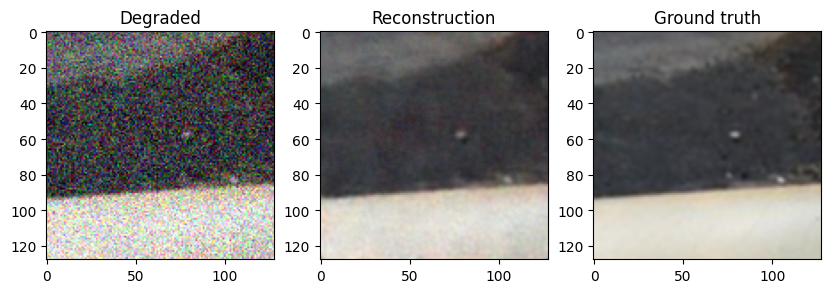

In [19]:
sample = next(iter(trainloader))
x = sample['noisy'][0:1].to(device)
target = sample['target'][0:1].to(device)
with torch.no_grad():
    output = model(x.to(device))


x = x.clip(0,1)
output = output.clip(0,1).to(device)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(output, target)))
myplot(x, output, target)

### Save model

In [22]:
# Save model
torch.save(model.state_dict(), './new_models/denoiser_unet_3_3.pth')